In [1]:
from pyzotero import zotero
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from datetime import datetime
from rake_nltk import Rake


In [2]:
import re
import nltk

# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

# nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import coo_matrix


In [3]:
from matplotlib import rc

rc(
    "font",
    **{
        "family": "sans-serif",
        "sans-serif": ["Helvetica"],
        "monospace": ["Inconsolata"],
        "serif": ["Baskerville"],
    }
)

rc("text", **{"usetex": True})
rc("text", **{"latex.preamble": "\\usepackage{sfmath}"})
rc("hatch", **{"linewidth": 0.45})


In [4]:
%matplotlib inline

# plot constants
dotsize = 2.
linewidth = .5
fontsize = 12

In [5]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


# See If You Can Load the Dataframe From a Saved Version


In [6]:
try:
    df = pd.read_pickle("CCA_processed.pickle")
except FileNotFoundError:
    print("Downloading references from Zotero instead")
    zot = zotero.Zotero(436, "user", "qmf7yjuu8uegfsa3p4p7zllk")
    collections = zot.collections()
    #     for c in collections:
    #     print(c["data"]["name"], c["data"]["key"])
    cca = zot.everything(zot.collection_items_top("96MNUEBN"))
    df = pd.DataFrame(
        {
            "title": [itm["data"]["title"] for itm in cca],
            "date": [itm["meta"]["parsedDate"][0:4] for itm in cca],
            "abstract": [itm["data"]["abstractNote"] for itm in cca],
        }
    )
    df["date"] = pd.to_datetime(df["date"])
    df["abstract_clean"] = df.apply(lambda x: cleanup(x.abstract), axis=1)
df.head()


,title,date,abstract,word_count,abstract_clean
0,Adaptation to Coastal Storms in Atlantic Canad...,2018-01-01,In order to improve the resilience of social-e...,162,order improve resilience social ecological sys...
1,Adaptation to Coastal Storms in Atlantic Canad...,2018-01-01,"In this chapter, we describe the methodologica...",123,chapter describe methodological approach selec...
2,"A regional, multi-sectoral and integrated asse...",2005-01-01,The 'Regional Climate Change Impact and Respon...,198,regional impact response study east anglia nor...
3,Bridging the gap: empowering decision-making f...,2006-01-01,"The methods, tools and outputs of the UK Clima...",231,method tool output uk impact programme ukcip b...
4,The Value of Linking Mitigation and Adaptation...,2009-01-01,There are two principal strategies for managin...,254,principal strategy managing risk mitigation re...


In [122]:
zot = zotero.Zotero(436, "user", "qmf7yjuu8uegfsa3p4p7zllk")
cca = zot.everything(zot.collection_items_top("96MNUEBN"))
df_b = pd.DataFrame(
    {
        "title": [itm["data"]["title"] for itm in cca],
        "creator": [itm["meta"].get("creatorSummary", "Unknown") for itm in cca],
        "date": [itm["meta"]["parsedDate"][0:4] for itm in cca],
        "abstract": [itm["data"]["abstractNote"] for itm in cca],
    }
)


In [123]:
df_b.head()


,title,creator,date,abstract
0,The psychological impacts of global climate ch...,Doherty and Clayton,2011,
1,Construcciones de la psicología al abordaje de...,Sapiains Arrué and Ugarte Caviedes,2017,Multiple studies show that the integration of ...
2,Contribuciones de la Psicología al abordaje de...,Arrué and Ugarte Caviedes,2017,Multiple studies show that the integration of ...
3,"Awareness, Risk Perception, and Protective Beh...",Madrigano et al.,2018,Preventing heat-related illness and death requ...
4,Resilient futures of a small island: A partici...,Hernandez et al.,2018,Adaptation to climate change has been consider...


In [124]:
df_b["abstract_clean"] = df_b.apply(lambda x: cleanup(x.abstract, stop_words), axis=1)


In [125]:
df_b["Risk"] = np.where(df_b["abstract_clean"].str.contains("risk"), "TRUE", "FALSE")


In [164]:
len(
    df_b[["creator", "date", "Risk"]][
        df_b["abstract_clean"].str.contains("risk")
        & df_b["abstract_clean"].str.contains("flood")
    ].sort_values(by=["date", "creator"])
)


25

In [88]:
df_countries["match_year"] = df_countries.apply(lambda x: x.Year.year, axis=1)


In [126]:
df_countries["Author"] = df_countries["Author"].astype(str)
df_b["creator"] = df_b["creator"].astype(str)
df_b["date"] = df_b["date"].astype(int)


In [153]:
print(
    df_b[["creator", "date", "Risk"]][df_b["Risk"].str.contains("TRUE")]
    .sort_values(by=["date", "creator"])
    .to_string()
)


                         creator  date  Risk
34              van Aalst et al.  2008  TRUE
31                 Ayers and Huq  2009  TRUE
32                Preston et al.  2009  TRUE
30                 Coffee et al.  2010  TRUE
22                 McEvoy et al.  2010  TRUE
28                      Reusswig  2010  TRUE
56                 Conlon et al.  2011  TRUE
20                           Ebi  2011  TRUE
17                         Moser  2011  TRUE
57                    Nye et al.  2011  TRUE
15             Pontee and Morris  2011  TRUE
12                          Webb  2011  TRUE
58              Alexander et al.  2012  TRUE
60                   Buys et al.  2012  TRUE
64               Helgeson et al.  2012  TRUE
10                       Johnson  2012  TRUE
66                  Myers et al.  2012  TRUE
59                       Pidgeon  2012  TRUE
65                       Pidgeon  2012  TRUE
88                Bhadwal et al.  2013  TRUE
73            Biagini and Miller  2013  TRUE
74        

In [128]:
new_df = pd.merge(
    df_countries,
    df_b[["creator", "date", "Risk"]],
    how="left",
    left_on=["Author", "match_year"],
    right_on=["creator", "date"],
)


# Utility Functions


In [7]:
def cleanup(txt, stop_words):
    """ Clean up abstract text for statistics """
    text = re.sub("[^a-zA-Z]", " ", txt)
    # Convert to lowercase
    text = text.lower()
    # Remove tags
    text = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", text)
    # Remove special characters and digits
    text = re.sub("(\\d|\\W)+", " ", text)
    text = text.split()
    # Stemming
    ps = PorterStemmer()
    # Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in stop_words]
    text = " ".join(text)
    return text


# Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


# Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2, 2), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


# Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3, 3), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)


def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""

    # use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    # word index and corresponding tf-idf score
    for idx, score in sorted_items:

        # keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    # create a tuple of feature, score
    # results = zip(feature_vals,score_vals)
    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]] = score_vals[idx]

    return results


def custom_bars(series, cmap):
    data_colour = [x / max(series) for x in series]
    my_cmap = plt.cm.get_cmap(cmap)
    colours = my_cmap(data_colour)
    return colours


In [8]:
# earliest and latest date criteria
start_date = datetime(2005, 1, 1)
end_date = datetime(2018, 1, 1)
mask = (df["date"] >= start_date) & (df["date"] <= end_date)


In [92]:
df.to_pickle("CCA_processed.pickle")


# Graph Research Effort Over Time


<Figure size 432x288 with 0 Axes>

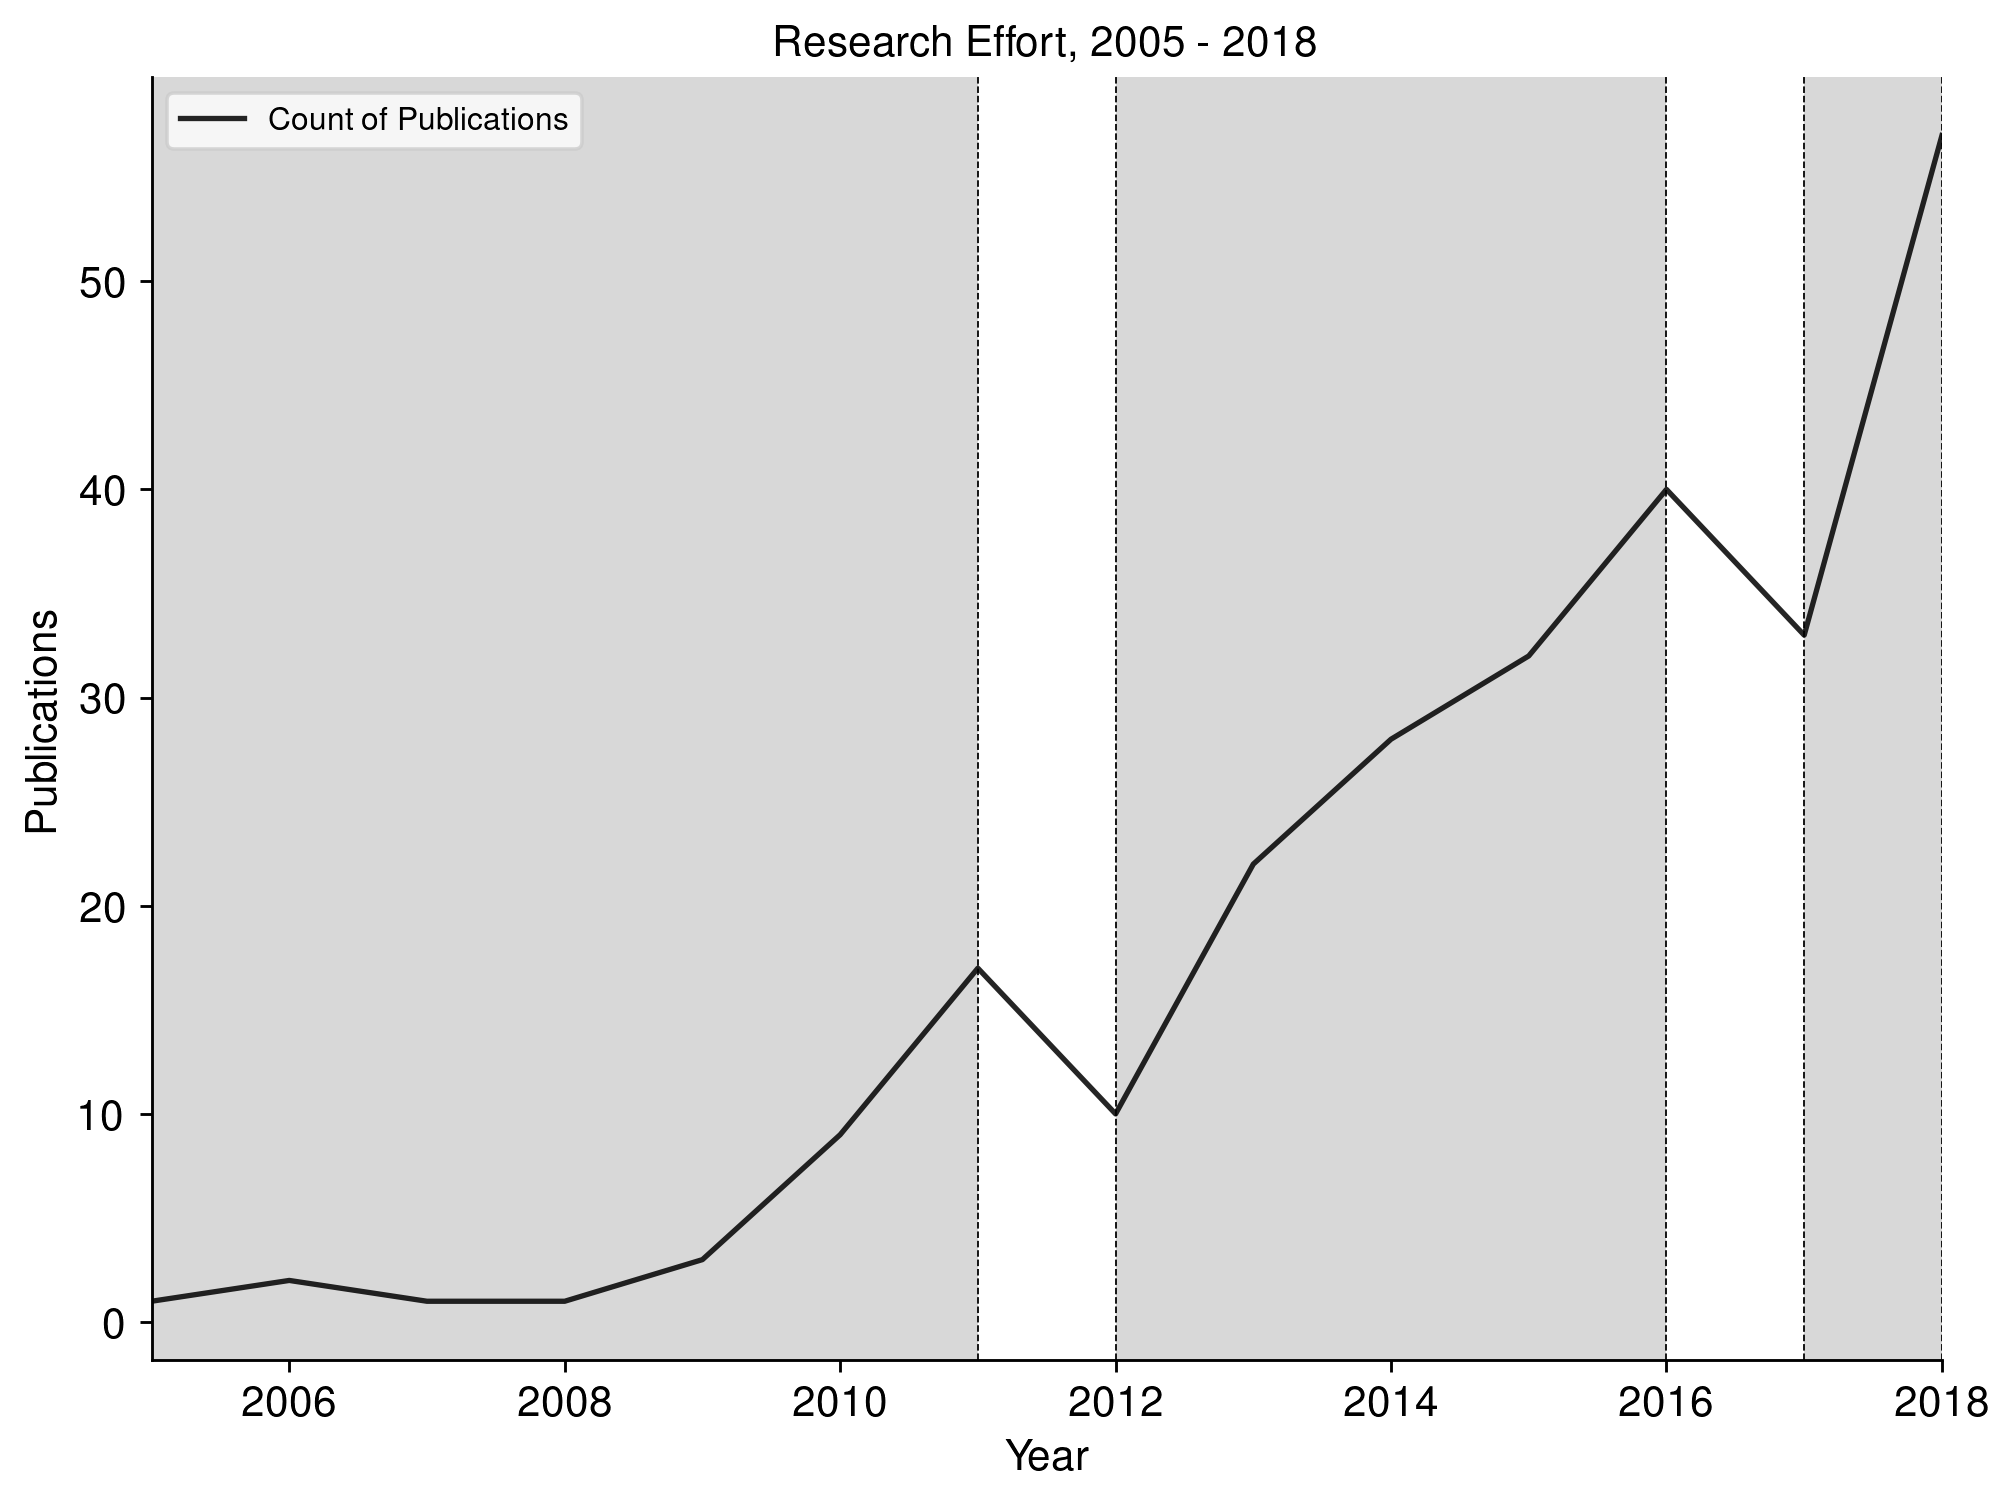

In [9]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(8.0, 6.0), dpi=255)

ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines['bottom'].set_visible(True)
# ax.spines['left'].set_visible(True)
ax.set_facecolor("none")
df.loc[mask].date.groupby(df.date.dt.year).agg({"count"}).plot(
    ax=ax,
    color="black",
    alpha=0.85,
    #     title="Publications by Year",
    fontsize=fontsize,
)
lines = [2011, 2012, 2016, 2017, 2018]
for line in lines:
    plt.axvline(x=line, color="black", lw=0.5, linestyle="--")
plt.axvspan(2005, 2011, facecolor="grey", alpha=0.3)
plt.axvspan(2012, 2016, facecolor="grey", alpha=0.3)
plt.axvspan(2017, 2018, facecolor="grey", alpha=0.3)
leg = ax.legend(["Count of Publications"], fontsize=9)
ax.set_ylabel("Publications", fontsize=fontsize)
plt.title("Research Effort, 2005 - 2018")
ax.set_xlabel("Year", fontsize=fontsize)
plt.tight_layout()
plt.savefig("time.png", dpi=300)
plt.show()


# Preliminary Text Analysis


In [81]:
r = Rake()


In [137]:
key_phrases = []
for idx, row in df.iterrows():
    r.extract_keywords_from_text(row.abstract)
    # extract top 5 phrases
    key_phrases.append(r.get_ranked_phrases_with_scores()[0:9])


In [150]:
key_phrases[10]


[(23.833333333333332, 'physical climate change scientists agree'),
 (22.25, 'success factors typifying best practice'),
 (22.25, 'researching best practice stakeholder collaboration'),
 (16.833333333333332, 'effectively address climate change'),
 (15.833333333333332, 'characterize climate adaptation strategies'),
 (15.0, 'deliberative democratic practice across'),
 (13.0, 'develop resilient cities based'),
 (9.5, 'supporting institutional strategies'),
 (9.0, 'regional western australia')]

In [184]:
df["word_count"] = df["abstract"].apply(lambda x: len(str(x).split(" ")))
df[["abstract", "word_count"]].head()


,abstract,word_count
0,In order to improve the resilience of social-e...,162
1,"In this chapter, we describe the methodologica...",123
2,The 'Regional Climate Change Impact and Respon...,198
3,"The methods, tools and outputs of the UK Clima...",231
4,There are two principal strategies for managin...,254


In [185]:
# descriptive statistics
df.word_count.describe()


count    258.000000
mean     205.131783
std       77.624546
min        1.000000
25%      159.250000
50%      200.500000
75%      244.000000
max      600.000000
Name: word_count, dtype: float64

In [10]:
# 20 most frequently-occurring words in the abstracts
freq = pd.Series(" ".join(df["abstract"]).split()).value_counts()[:20]
freq


and           2549
the           2128
of            2045
to            1649
in            1173
climate        914
a              791
change         577
for            545
that           532
is             459
on             398
adaptation     392
with           370
as             342
are            322
The            286
public         264
by             241
this           215
dtype: int64

In [11]:
# 20 least-common words
frequ = pd.Series(" ".join(df["abstract"]).split()).value_counts()[-20:]
frequ


ready           1
Singaporeans    1
amplify         1
premiums        1
ahead           1
digdeeper       1
(Upper          1
subverting      1
trails,         1
therefore,      1
act.            1
change?'        1
begs            1
Network,        1
relief          1
2010;           1
laid            1
also,           1
work',          1
responding.     1
dtype: int64

# Text Pre-Processing


In [12]:
# Create a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
# Create a list of custom stopwords
new_words = [
    "using",
    "show",
    "result",
    "large",
    "also",
    "iv",
    "one",
    "two",
    "new",
    "previously",
    "shown",
]
# these are the search keywords
new_words.extend(["climate", "change", "adaptation", "engagement", "public", "citizen"])
# these are metadata words, we definitely don't want these
new_words.extend(
    [
        "paper",
        "ltd",
        "limited",
        "right",
        "reserved",
        "elsevier",
        "john",
        "wiley",
        "sons",
        "article",
        "please",
        "visit",
        "case",
        "study",
    ]
)
stop_words = stop_words.union(new_words)

df["abstract_clean"] = df.apply(lambda x: cleanup(x.abstract, stop_words), axis=1)


<Figure size 432x288 with 0 Axes>

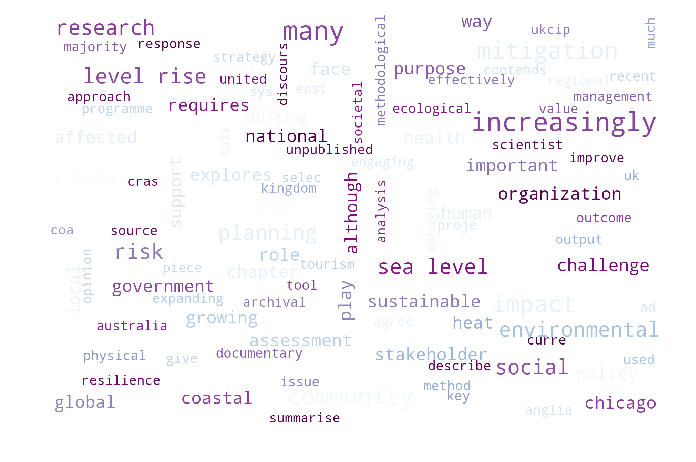

In [12]:
# build a word cloud
plt.clf()
fig, ax = plt.subplots(1, figsize=(8.0, 6.0), dpi=100)
wordcloud = WordCloud(
    background_color="white",
    width=1800,
    height=1200,
    stopwords=stop_words,
    max_words=100,
    max_font_size=75,
    random_state=42,
    colormap="BuPu",
).generate(str(df.abstract_clean))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("wordcloud.png", dpi=300)
plt.show()


In [13]:
cv = CountVectorizer(
    max_df=0.8, stop_words=stop_words, max_features=10000, ngram_range=(1, 3)
)
X = cv.fit_transform(df.abstract_clean)


In [14]:
list(cv.vocabulary_.keys())[:10]


['order',
 'improve',
 'resilience',
 'social',
 'ecological',
 'system',
 'small',
 'rural',
 'coastal',
 'community']

In [15]:
# Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(df.abstract_clean, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns = ["Word", "Freq"]


# Graph Most Frequent Words


<Figure size 432x288 with 0 Axes>

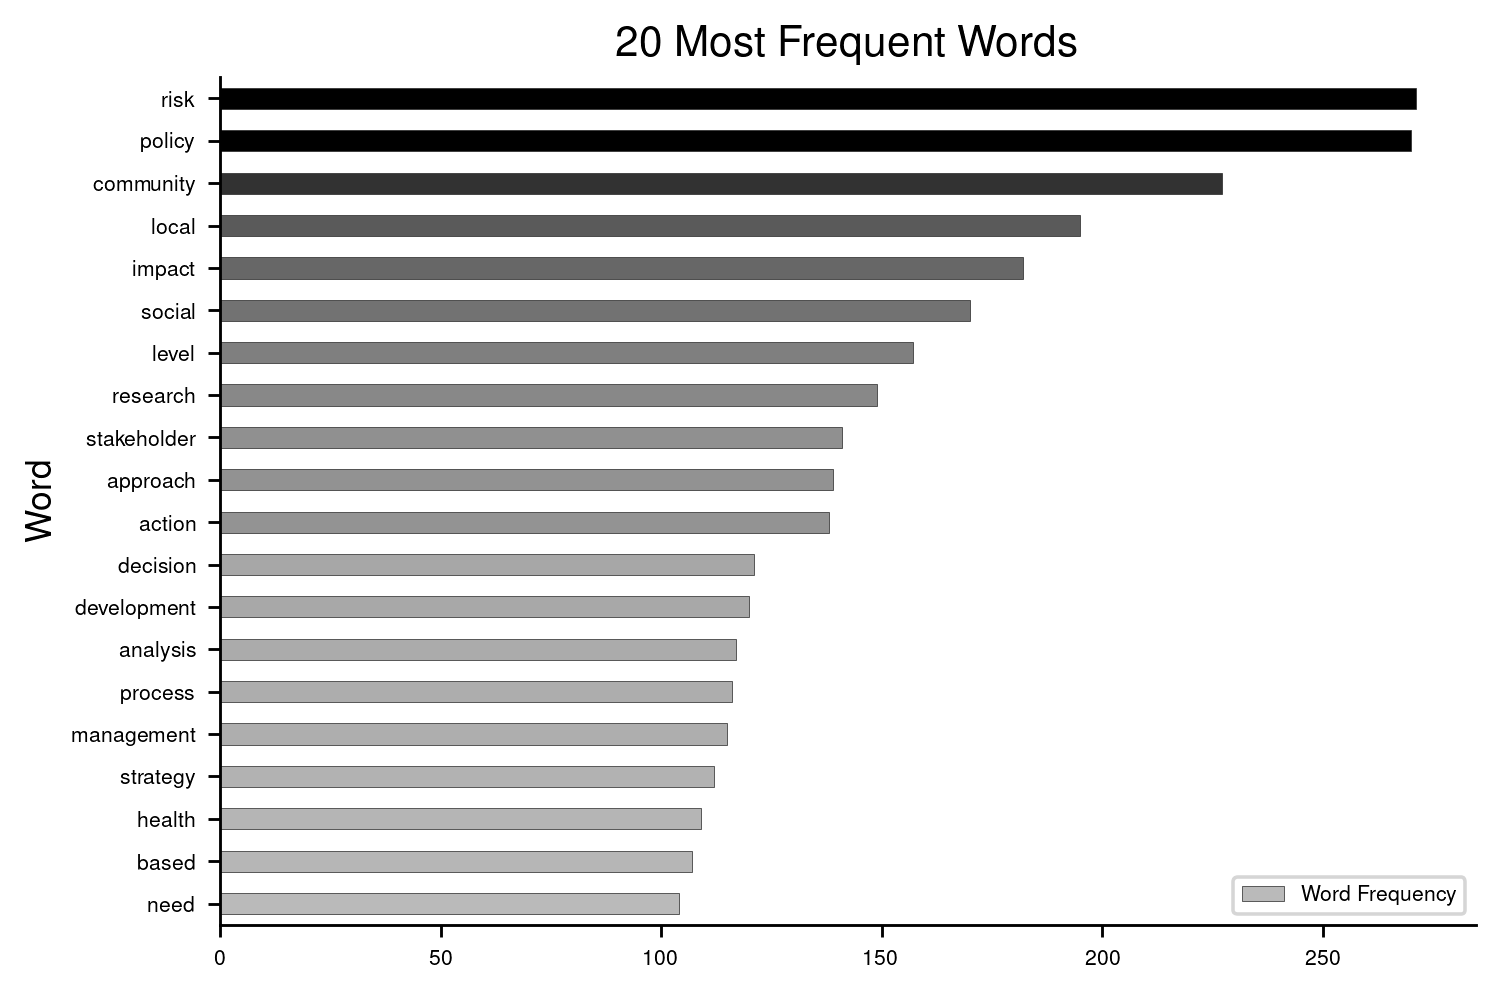

In [16]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(6.0, 4.0), dpi=255)

c = custom_bars(top_df.sort_values(by=["Freq"]).Freq, "Greys")

top_df.sort_values(by=["Freq"]).plot.barh(
    ax=ax, x="Word", y="Freq", fontsize=6, color=c, edgecolor="#282828", lw=0.2
)
leg = ax.legend(["Word Frequency"], fontsize=6)
plt.title("20 Most Frequent Words")
ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_facecolor("none")
# plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("words_single.png", dpi=300)
plt.show()


In [17]:
top2_words = get_top_n2_words(df.abstract_clean, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns = ["Bigram", "Freq"]


<Figure size 432x288 with 0 Axes>

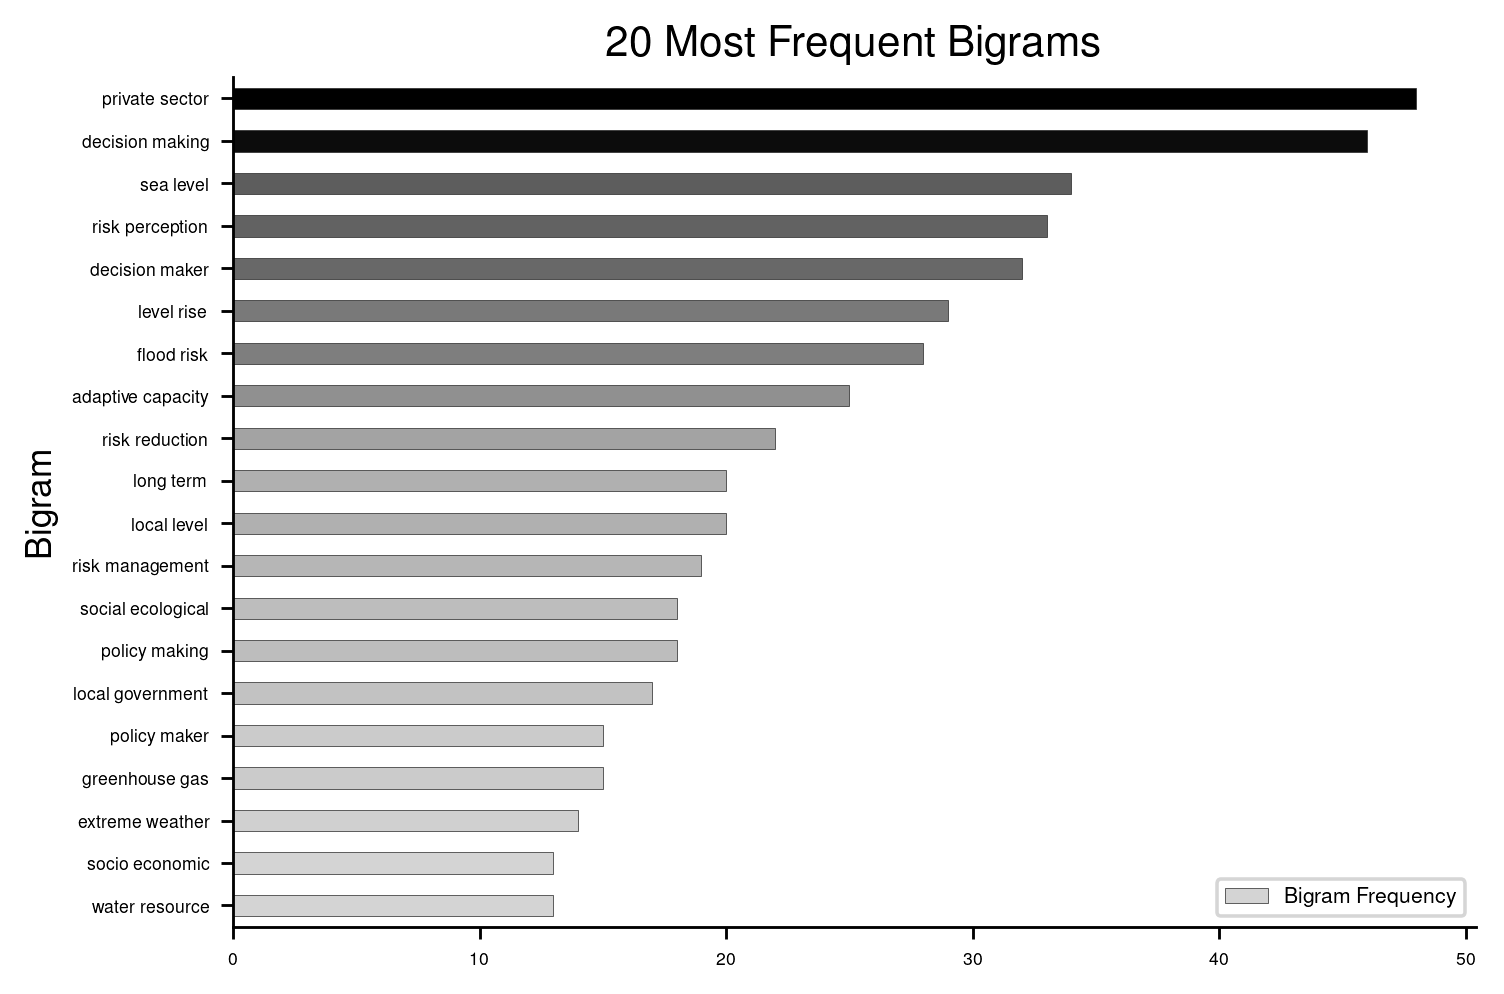

In [18]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(6.0, 4.0), dpi=255)

c = custom_bars(top2_df.sort_values(by=["Freq"]).Freq, "Greys")

top2_df.sort_values(by=["Freq"]).plot.barh(
    ax=ax, x="Bigram", y="Freq", fontsize=5, color=c, edgecolor="#282828", lw=0.2
)
plt.title("20 Most Frequent Bigrams")
leg = ax.legend(["Bigram Frequency"], fontsize=6)
ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_facecolor("none")
# plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("bigrams.png", dpi=300)
plt.show()


In [19]:
top3_words = get_top_n3_words(df.abstract_clean, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns = ["Trigram", "Freq"]


<Figure size 432x288 with 0 Axes>

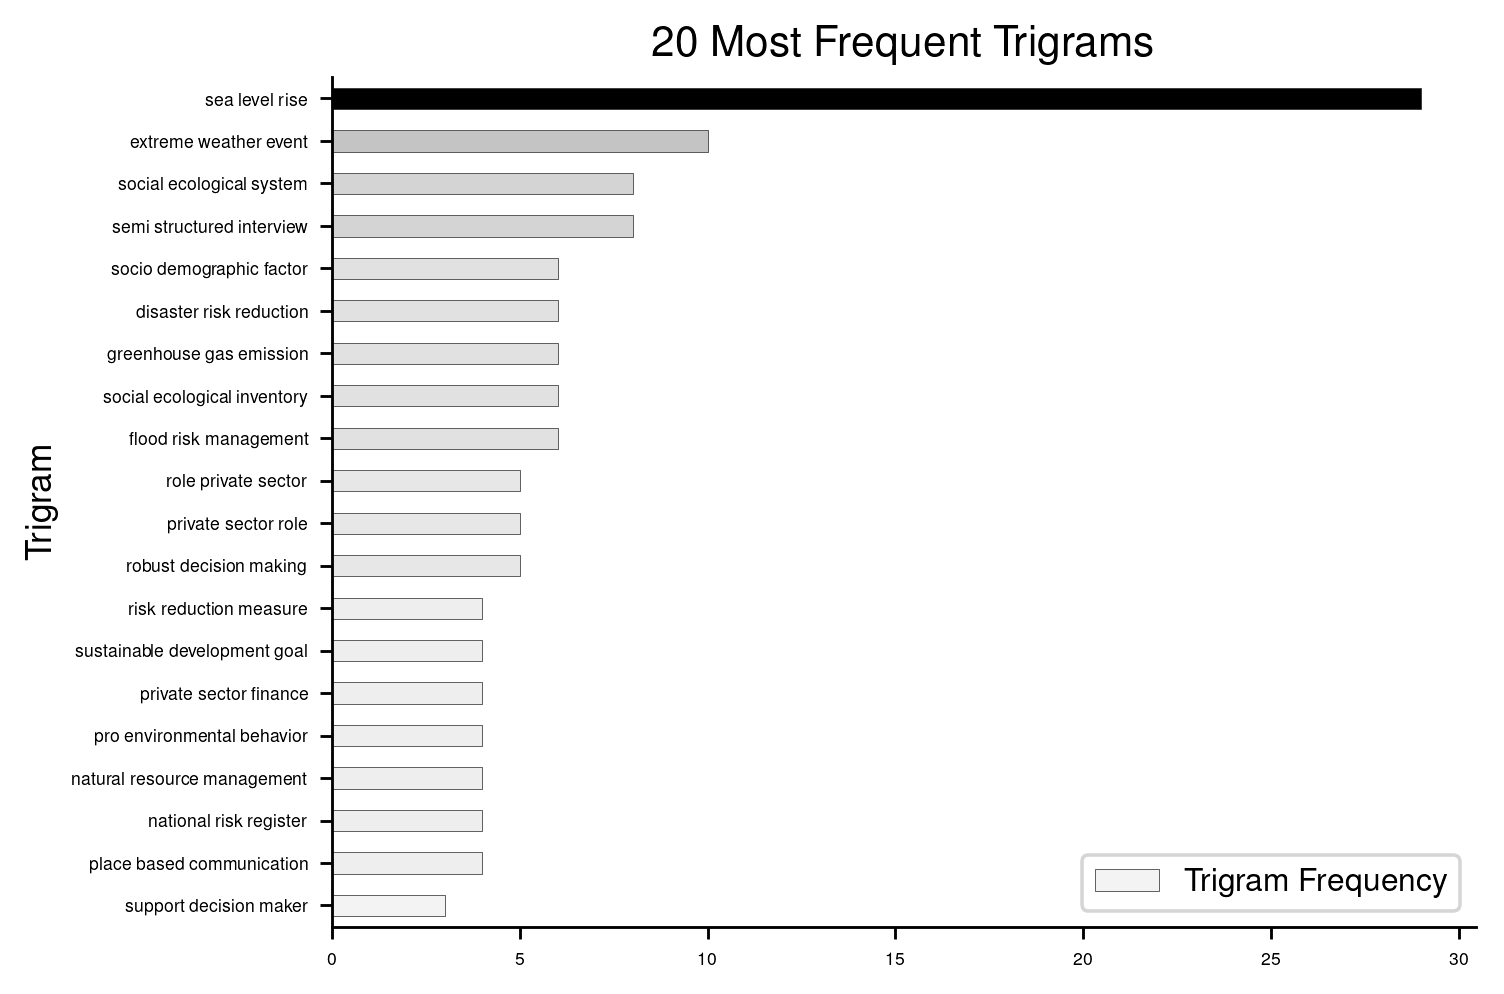

In [20]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(6.0, 4.0), dpi=255)

c = custom_bars(top3_df.sort_values(by=["Freq"]).Freq, "Greys")

top3_df.sort_values(by=["Freq"]).plot.barh(
    ax=ax, x="Trigram", y="Freq", fontsize=5, color=c, edgecolor="#282828", lw=0.2
)
plt.title("20 Most Frequent Trigrams")
leg = ax.legend(["Trigram Frequency"], fontsize=9)
ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_facecolor("none")
# plt.xticks(rotation=80)
plt.tight_layout()
plt.savefig("trigrams.png", dpi=300)
plt.show()


In [21]:
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names = cv.get_feature_names()

# fetch document for which keywords needs to be extracted
doc = df.abstract_clean.iloc[50]

tf_idf_vector = tfidf_transformer.transform(cv.transform([doc]))
# sort the tf-idf vectors by descending order of scores
sorted_items = sort_coo(tf_idf_vector.tocoo())
# extract only the top n; n here is 10
keywords = extract_topn_from_vector(feature_names, sorted_items, 5)


In [22]:
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k, keywords[k])



Abstract:
developing country need private sector engaged identifying risk response measure prioritize highly importance role private sector evident lesson drawn increasing amount empirical experience project supported fund successful private sector catalyse greater investment reducing vulnerability turn accelerate replication resilient technology service core development sector especially developing country investment long lived infrastructure growing rapidly private sector company integrate strategy investment economic interest well client interest interest country operate unfortunately private sector effort widely understood seen good business practice generally face several obstacle policy incentivize investment communicating risk offering incentive resilience enhancing measure necessary putting place regulation avoid shifting risk onto stronger private partnership help enhance resilience time create business opportunity private firm develop many product service enable lower cost e

In [24]:
df[df.abstract_clean.str.contains("risk")].date.groupby(df.date.dt.year).agg({"count"})


,count
date,
2008,1
2009,2
2010,3
2011,6
2012,7
2013,6
2014,10
2015,12
2016,19


In [26]:
df[df.abstract_clean.str.contains("risk")].date.groupby(df.date.dt.year).agg(
    {"count"}
).sum()


count    101
dtype: int64

In [27]:
df.groupby(df.date.dt.year).agg({"count"})


,title,date,abstract,word_count,abstract_clean
,count,count,count,count,count
date,,,,,
2005,1,1,1,1,1
2006,2,2,2,2,2
2007,1,1,1,1,1
2008,1,1,1,1,1
2009,3,3,3,3,3
2010,9,9,9,9,9
2011,17,17,17,17,17
2012,10,10,10,10,10


# Geographic Classification


In [38]:
df_countries.head()


,idx,Author,Year,Country,Risk,Risk Type,Scale,Rural / Urban,Classification,Method of Engagement,Focus,Summary
0,1,Hedger et al,2006,UK,NaN,NaN,NaN,NaN,N / A,N / A,N / A,What is UKCIP (UK Climate Impacts Programme)? ...
1,2,Moser,2006,UK,NaN,NaN,NaN,NaN,N / A,N / A,Researcher-led,"Communicating climate change - Audiences, fram..."
2,3,Endfield,2007,UK,NaN,NaN,NaN,NaN,N / A,N / A,Researcher-led,Archival exploration of climate variability an...
3,4,van Aalst et al,2008,UK,NaN,NaN,NaN,NaN,N / A,N / A,Public strategy,Lit review of Participatory Community Risk Ass...
4,5,Hoeppner,2009,UK,NaN,NaN,NaN,NaN,N / A,N / A,Researcher-led,Public engagement in climate change - Disjunct...


In [45]:
df_countries = pd.read_excel(
    "/Users/sth/OneDrive - TCDUD.onmicrosoft.com/WIREs 2018/summaries.xlsx",
    usecols=["Author", "Year", "Country", "Summary"],
)
df_countries.head()


,Author,Year,Country,Summary
0,Hedger et al,2006,UK,What is UKCIP (UK Climate Impacts Programme)? ...
1,Moser,2006,UK,"Communicating climate change - Audiences, fram..."
2,Endfield,2007,UK,Archival exploration of climate variability an...
3,van Aalst et al,2008,UK,Lit review of Participatory Community Risk Ass...
4,Hoeppner,2009,UK,Public engagement in climate change - Disjunct...


In [46]:
df_countries["Year"] = pd.to_datetime(df_countries["Year"], format="%Y")
df_countries.dropna(inplace=True)
uniq = set(list(df_countries.Country))


In [47]:
# map countries to areas
mappings = {
    "AUS": "AUS / NZ",
    "NZ": "AUS / NZ",
    "BEL": "Europe",
    "BGDSH": "Rest of World",
    "BRA": "Rest of World",
    "CAN": "North America",
    "CH": "Europe",
    "CHIL": "Rest of World",
    "DE": "Europe",
    "DK": "Europe",
    "FI": "Europe",
    "FR": "Europe",
    "HK": "Rest of World",
    "IE": "Europe",
    "IND": "Rest of World",
    "INDNO": "Rest of World",
    "IRN": "Rest of World",
    "IT": "Europe",
    "JAP": "Rest of World",
    "KEN": "Rest of World",
    "MAC": "Rest of World",
    "MAL": "Europe",
    "NIG": "Rest of World",
    "NL": "Europe",
    "NO": "Europe",
    "POR": "Europe",
    "PRC": "Rest of World",
    "ROC": "Rest of World",
    "SA": "Rest of World",
    "SING": "Rest of World",
    "SWE": "Europe",
    "TWN": "Rest of World",
    "UGND": "Rest of World",
    "UK": "UK",
    "URG": "Rest of World",
    "US": "North America",
    "VNM": "Rest of World",
}


In [48]:
# assign area by looking up countries
df_countries.Country = df_countries["Country"].astype("category")
df_countries["Area"] = df_countries["Country"].apply(lambda x: mappings.get(x))
df_countries.Area = df_countries["Area"].astype("category")
df_countries.head()


,Author,Year,Country,Summary,Area
0,Hedger et al,2006-01-01,UK,What is UKCIP (UK Climate Impacts Programme)? ...,UK
1,Moser,2006-01-01,UK,"Communicating climate change - Audiences, fram...",UK
2,Endfield,2007-01-01,UK,Archival exploration of climate variability an...,UK
3,van Aalst et al,2008-01-01,UK,Lit review of Participatory Community Risk Ass...,UK
4,Hoeppner,2009-01-01,UK,Public engagement in climate change - Disjunct...,UK


<Figure size 432x288 with 0 Axes>

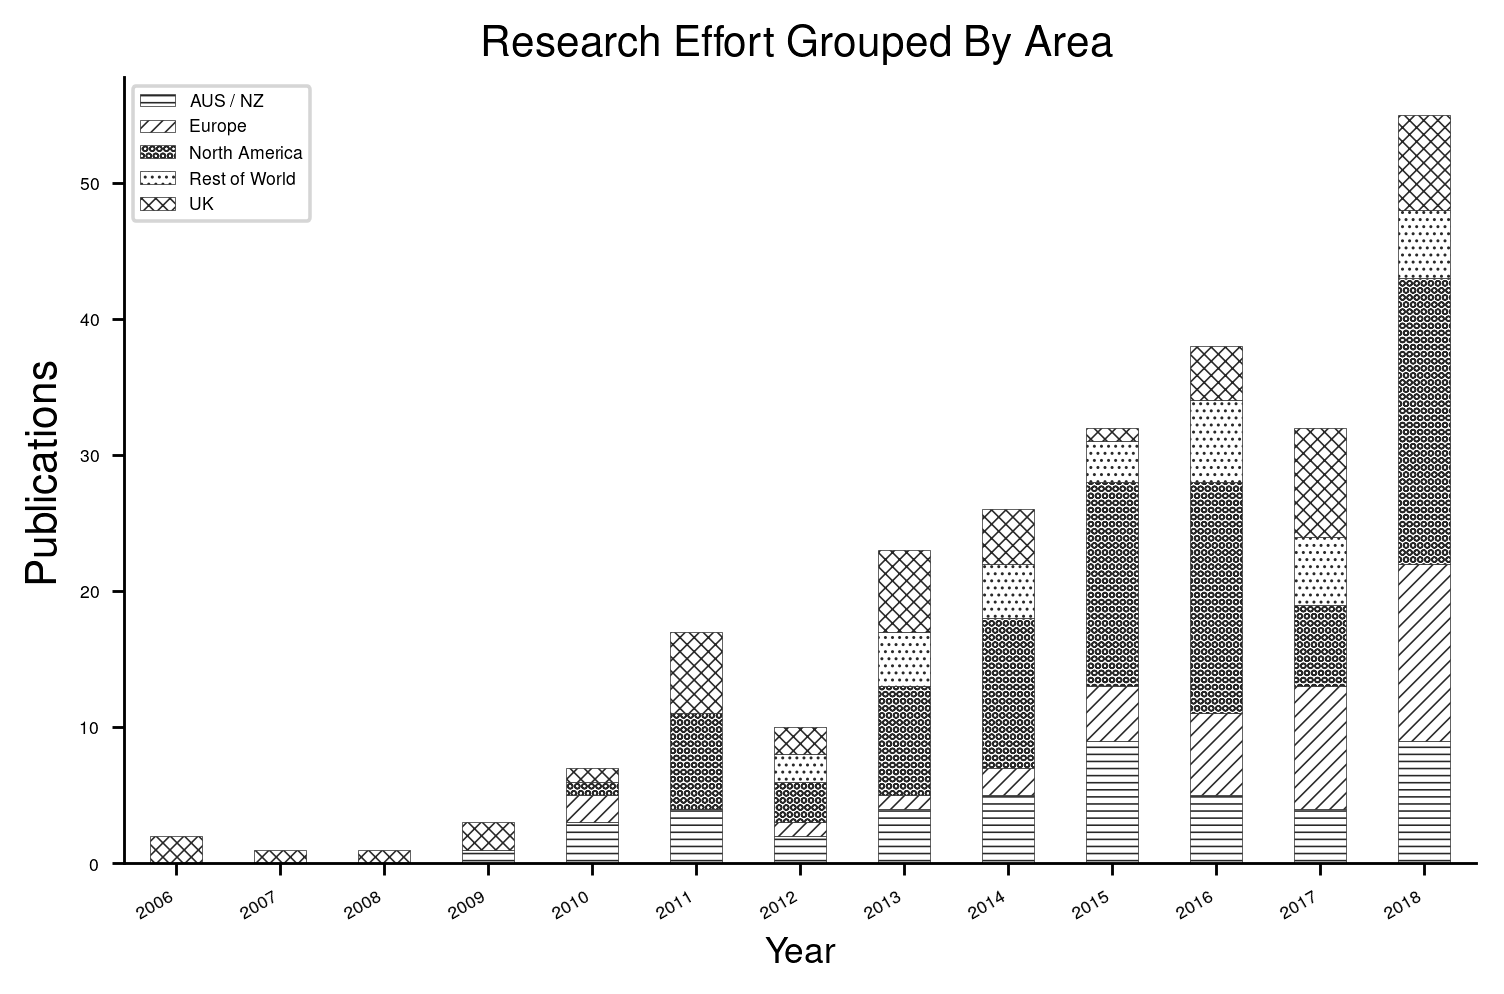

In [49]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(6.0, 4.0), dpi=255)

df_countries.set_index("Year").groupby(["Year", "Area"]).count()[
    "Country"
].unstack().plot(
    kind="bar",
    stacked=True,
    fontsize=5,
    color="#ffffff",
    edgecolor="#282828",
    lw=0.2,
    ax=ax,
)
plt.title("Research Effort Grouped By Area")
ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# manually create the tick labels, by pulling in the correct number of years
# and the lowest year value, formatted as a string
periods = len(df_countries.groupby("Year"))
ticklabels = pd.Series(
    pd.date_range(df_countries.Year.min().strftime("%Y"), freq="Y", periods=periods)
).dt.strftime("%Y")
ax.xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
fig.autofmt_xdate()

bars = ax.patches
# the choice of hatches could be automatically derived from the number of Areas
# doing it manually gives better control over adjacent patterns (so "/" isn't adjacent to "x")
ha = [h * periods for h in "-/O.x"]
hatches = "".join(ha)
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch * 6)
#     bar.set_color("b")
#     bar.set_edgecolor("red")
#     bar.set_facecolor("none")


ax.set_ylabel("Publications", fontsize=fontsize)
ax.legend(loc="upper left", ncol=1, fontsize=5)
ax.set_facecolor("none")
plt.tight_layout()
plt.savefig("areas.png", dpi=300)
plt.show()


In [51]:
df_countries.set_index("Year").groupby(["Year", "Area"]).agg({"count"})["Country"]


count
Year       Area                
2006-01-01 UK                 2
2007-01-01 UK                 1
2008-01-01 UK                 1
2009-01-01 AUS / NZ           1
           UK                 2
2010-01-01 AUS / NZ           3
           Europe             2
           North America      1
           UK                 1
2011-01-01 AUS / NZ           4
           North America      7
           UK                 6
2012-01-01 AUS / NZ           2
           Europe             1
           North America      3
           Rest of World      2
           UK                 2
2013-01-01 AUS / NZ           4
           Europe             1
           North America      8
           Rest of World      4
           UK                 6
2014-01-01 AUS / NZ           5
           Europe             2
           North America     11
           Rest of World      4
           UK                 4
2015-01-01 AUS / NZ           9
           Europe             4
           North America     15
           Rest of World      3
           UK                 1
2016-01-01 AUS / NZ           5
           Europe             6
           North America     17
           Rest of World      6
           UK                 4
2017-01-01 AUS / NZ           4
           Europe             9
           North America      6
           Rest of World      5
           UK                 8
2018-01-01 AUS / NZ           9
           Europe            13
           North America     21
           Rest of World      5
           UK                 7

In [52]:
pct = (
    df_countries.set_index("Year")
    .groupby(["Year", "Area"])
    .count()["Country"]
    .fillna(0)
    .astype(int)
    .unstack()
)
pct


Area,AUS / NZ,Europe,North America,Rest of World,UK
Year,,,,,
2006-01-01,0,0,0,0,2
2007-01-01,0,0,0,0,1
2008-01-01,0,0,0,0,1
2009-01-01,1,0,0,0,2
2010-01-01,3,2,1,0,1
2011-01-01,4,0,7,0,6
2012-01-01,2,1,3,2,2
2013-01-01,4,1,8,4,6
2014-01-01,5,2,11,4,4


<Figure size 432x288 with 0 Axes>

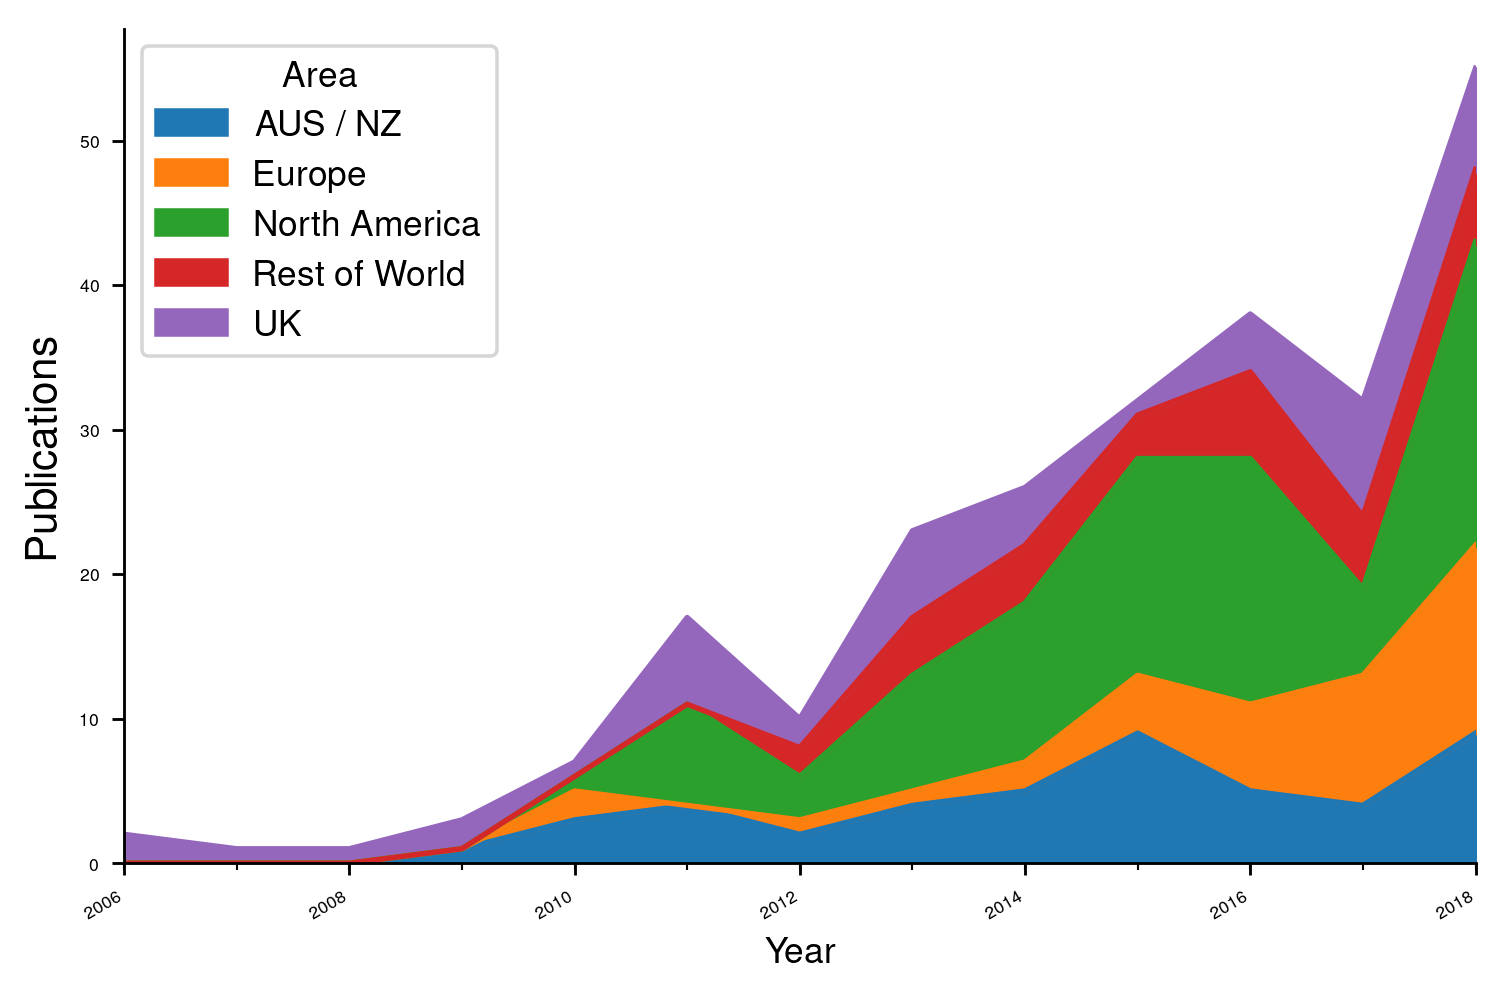

In [53]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(6.0, 4.0), dpi=255)
pct = (
    df_countries.set_index("Year")
    .groupby(["Year", "Area"])
    .count()["Country"]
    .unstack()
    .plot.area(ax=ax, fontsize=5)
)
ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Publications", fontsize=fontsize)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


In [56]:
# count per area, per year
pct = (
    df_countries.set_index("Year")
    .groupby(["Year", "Area"])
    .agg({"count"})
    .rename(columns={"count": "Percentage"})["Country"]
)
# percentage per area, per year
pcts = pct.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
pcts.sort_values(by=["Year", "Percentage"]).round(2)


Percentage
Year       Area                     
2006-01-01 UK                 100.00
2007-01-01 UK                 100.00
2008-01-01 UK                 100.00
2009-01-01 AUS / NZ            33.33
           UK                  66.67
2010-01-01 North America       14.29
           UK                  14.29
           Europe              28.57
           AUS / NZ            42.86
2011-01-01 AUS / NZ            23.53
           UK                  35.29
           North America       41.18
2012-01-01 Europe              10.00
           AUS / NZ            20.00
           Rest of World       20.00
           UK                  20.00
           North America       30.00
2013-01-01 Europe               4.35
           AUS / NZ            17.39
           Rest of World       17.39
           UK                  26.09
           North America       34.78
2014-01-01 Europe               7.69
           Rest of World       15.38
           UK                  15.38
           AUS / NZ            19.23
           North America       42.31
2015-01-01 UK                   3.12
           Rest of World        9.38
           Europe              12.50
           AUS / NZ            28.12
           North America       46.88
2016-01-01 UK                  10.53
           AUS / NZ            13.16
           Europe              15.79
           Rest of World       15.79
           North America       44.74
2017-01-01 AUS / NZ            12.50
           Rest of World       15.62
           North America       18.75
           UK                  25.00
           Europe              28.12
2018-01-01 Rest of World        9.09
           UK                  12.73
           AUS / NZ            16.36
           Europe              23.64
           North America       38.18

In [55]:
# Percentage per area, all years
pct = df_countries.set_index("Year").groupby(["Area"]).agg({"count"})["Country"]
pcts = pct.apply(lambda x: 100 * x / float(x.sum())).sort_values(
    by=["count"], ascending=False
)
pcts.round(2)


,count
Area,
North America,36.03
AUS / NZ,18.62
UK,18.22
Europe,15.38
Rest of World,11.74


# Find all papers which mention "risk"


In [58]:
df[df["abstract"].str.contains("risk")]


,title,date,abstract,word_count,abstract_clean
4,The Value of Linking Mitigation and Adaptation...,2009-01-01,There are two principal strategies for managin...,254,principal strategy managing risk mitigation re...
7,The New Climate Change Discourse: A Challenge ...,2010-01-01,The chapter gives an analysis of the shifting ...,196,chapter give analysis shifting social discours...
13,Community level adaptation to climate change: ...,2008-01-01,This paper explores the value of using communi...,260,explores value community risk assessment cras ...
15,Igniting change in local government: lessons l...,2009-01-01,Local governments and communities have a criti...,218,local government community critical role play ...
17,Preparing for a changing climate: The Chicago ...,2010-01-01,"The Chicago Climate Action Plan (CCAP), Chicag...",167,chicago action plan ccap chicago roadrnap redu...
19,Framing adaptation to climate-related extreme ...,2010-01-01,Whilst mitigation has dominated policy and res...,219,whilst mitigation dominated policy research ag...
21,Overview: Adaptive Management for the Health R...,2011-01-01,Climate change is expected to increase health ...,205,expected increase health risk country although...
25,Preventing cold-related morbidity and mortalit...,2011-01-01,Winter weather patterns are anticipated to bec...,206,winter weather pattern anticipated become vari...
26,New social directions in UK flood risk managem...,2011-01-01,This paper explores the evolution of a more so...,133,explores evolution sociotechnical variety floo...
27,Managed retreat of coastal communities: unders...,2012-01-01,Managed retreat - the relocation of homes and ...,202,managed retreat relocation home infrastructure...
